# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install libraries

# Import Libraries

In [ ]:
#Load the required libraries

import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')


from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
import joblib
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings("ignore")

# Import Data

In [ ]:
data_BTC = pd.read_csv("data/bitcoin.csv")

In [ ]:
data_BTC.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,9588.74,9630.00,9579.34,9617.06,546.960415,2019-09-01 00:59:59.999,5.257943e+06,7428,261.131656,2.510480e+06
1,2019-09-01 01:00:00,9617.06,9642.58,9612.08,9614.99,453.105152,2019-09-01 01:59:59.999,4.362498e+06,5789,258.764082,2.491295e+06
2,2019-09-01 02:00:00,9614.99,9616.00,9595.76,9605.78,458.004517,2019-09-01 02:59:59.999,4.400751e+06,5485,321.355630,3.088171e+06
3,2019-09-01 03:00:00,9606.12,9624.01,9605.78,9623.02,633.588749,2019-09-01 03:59:59.999,6.092024e+06,5500,446.853542,4.296649e+06
4,2019-09-01 04:00:00,9623.02,9630.21,9605.60,9614.46,542.260896,2019-09-01 04:59:59.999,5.216076e+06,5536,368.470786,3.544535e+06


Here's a breakdown of each feature:

- **open_time**: This represents the opening time of a specific period in Unix time format. Unix time is a way to represent time as the number of seconds that have elapsed since January 1, 1970.

- **open**: This refers to the opening price of the trading instrument at the given period.

- **high**: This represents the highest price reached by the trading instrument during the specified period.

- **low**: This denotes the lowest price reached by the trading instrument during the specified period.

- **close**: This indicates the closing price of the trading instrument at the given period.

- **volume**: This refers to the total volume, typically the quantity of the trading instrument, traded during the specified period.

- **close_time**: This represents the closing time of the specific period in Unix time format.

- **quote_volume**: This refers to the total volume in terms of the quote asset. The quote asset is the asset used to determine the value of the trading instrument.

- **count**: This represents the number of trades that occurred during the specified period.

- **taker_buy_volume**: This denotes the volume of the quote asset bought by takers (market takers) during the specified period.

- **taker_buy_quote_volume**: This represents the volume of the base asset bought by takers (market takers) during the specified period.

In [ ]:
# Renaming the column open_time

data_BTC.rename(columns = {'open_time':'date'}, inplace = True)

In [ ]:
data_BTC.head()

,date,open,high,low,close,Volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,9588.74,9630.00,9579.34,9617.06,546.960415,2019-09-01 00:59:59.999,5.257943e+06,7428,261.131656,2.510480e+06
1,2019-09-01 01:00:00,9617.06,9642.58,9612.08,9614.99,453.105152,2019-09-01 01:59:59.999,4.362498e+06,5789,258.764082,2.491295e+06
2,2019-09-01 02:00:00,9614.99,9616.00,9595.76,9605.78,458.004517,2019-09-01 02:59:59.999,4.400751e+06,5485,321.355630,3.088171e+06
3,2019-09-01 03:00:00,9606.12,9624.01,9605.78,9623.02,633.588749,2019-09-01 03:59:59.999,6.092024e+06,5500,446.853542,4.296649e+06
4,2019-09-01 04:00:00,9623.02,9630.21,9605.60,9614.46,542.260896,2019-09-01 04:59:59.999,5.216076e+06,5536,368.470786,3.544535e+06


In [ ]:
data_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32821 entries, 0 to 32820
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    32821 non-null  object 
 1   open                    32821 non-null  float64
 2   high                    32821 non-null  float64
 3   low                     32821 non-null  float64
 4   close                   32821 non-null  float64
 5   Volume                  32821 non-null  float64
 6   close_time              32821 non-null  object 
 7   quote_volume            32821 non-null  float64
 8   count                   32821 non-null  int64  
 9   taker_buy_volume        32821 non-null  float64
 10  taker_buy_quote_volume  32821 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.8+ MB


In [ ]:
# Removing close time column

data_BTC = data_BTC.drop(columns=['close_time'])

In [ ]:
data_BTC.head()

,date,open,high,low,close,Volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,9588.74,9630.00,9579.34,9617.06,546.960415,5.257943e+06,7428,261.131656,2.510480e+06
1,2019-09-01 01:00:00,9617.06,9642.58,9612.08,9614.99,453.105152,4.362498e+06,5789,258.764082,2.491295e+06
2,2019-09-01 02:00:00,9614.99,9616.00,9595.76,9605.78,458.004517,4.400751e+06,5485,321.355630,3.088171e+06
3,2019-09-01 03:00:00,9606.12,9624.01,9605.78,9623.02,633.588749,6.092024e+06,5500,446.853542,4.296649e+06
4,2019-09-01 04:00:00,9623.02,9630.21,9605.60,9614.46,542.260896,5.216076e+06,5536,368.470786,3.544535e+06


# EDA

## Converting to Datetime

In [ ]:
# Converting the Date column from object to datetime
data_BTC[["date"]] = data_BTC[["date"]].apply(pd.to_datetime)

In [ ]:
data_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32821 entries, 0 to 32820
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    32821 non-null  datetime64[ns]
 1   open                    32821 non-null  float64       
 2   high                    32821 non-null  float64       
 3   low                     32821 non-null  float64       
 4   close                   32821 non-null  float64       
 5   Volume                  32821 non-null  float64       
 6   quote_volume            32821 non-null  float64       
 7   count                   32821 non-null  int64         
 8   taker_buy_volume        32821 non-null  float64       
 9   taker_buy_quote_volume  32821 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.5 MB


## Missing Data

In [ ]:
data_BTC.isnull().any()

date                      False
open                      False
high                      False
low                       False
close                     False
Volume                    False
quote_volume              False
count                     False
taker_buy_volume          False
taker_buy_quote_volume    False
dtype: bool

# Modeling

In [ ]:
data_BTC.head()

,date,open,high,low,close,Volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,9588.74,9630.00,9579.34,9617.06,546.960415,5.257943e+06,7428,261.131656,2.510480e+06
1,2019-09-01 01:00:00,9617.06,9642.58,9612.08,9614.99,453.105152,4.362498e+06,5789,258.764082,2.491295e+06
2,2019-09-01 02:00:00,9614.99,9616.00,9595.76,9605.78,458.004517,4.400751e+06,5485,321.355630,3.088171e+06
3,2019-09-01 03:00:00,9606.12,9624.01,9605.78,9623.02,633.588749,6.092024e+06,5500,446.853542,4.296649e+06
4,2019-09-01 04:00:00,9623.02,9630.21,9605.60,9614.46,542.260896,5.216076e+06,5536,368.470786,3.544535e+06


## Daily Dataframe

In [ ]:
# BTC Daily resampling taking the mean value

data_BTC.set_index('date', inplace=True)  # Set 'date' column as the index

BTC_daily = data_BTC.resample('24H').mean()
BTC_daily = BTC_daily.reset_index()

BTC_daily.head()

,date,open,high,low,close,Volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01,9608.415417,9638.866250,9587.699583,9614.007083,814.391868,7.854720e+06,7971.833333,481.067108,4.644335e+06
1,2019-09-02,9904.533333,9960.438333,9885.246667,9929.980000,1864.177004,1.868592e+07,14756.458333,1047.512339,1.049724e+07
2,2019-09-03,10496.003750,10552.840000,10455.567083,10507.604583,1999.932366,2.106740e+07,17336.500000,1030.595969,1.085368e+07
3,2019-09-04,10544.943333,10596.092917,10493.059583,10543.090833,1830.995376,1.931360e+07,15977.375000,926.836152,9.780472e+06
4,2019-09-05,10549.111250,10601.045000,10507.465417,10548.702500,1415.456693,1.495256e+07,12910.250000,688.964492,7.287545e+06


In [ ]:
# Train/Test Split

split_date_day = "2022-09-01"

train_split_day = BTC_daily['date'] <= split_date_day
test_split_day = BTC_daily['date'] > split_date_day

train_ar_day = BTC_daily[train_split_day]
test_ar_day = BTC_daily[test_split_day]

columns_day = ['open', 'high', 'low', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']

X_train_d, y_train_d = train_ar_day[columns_day], train_ar_day.close
X_test_d, y_test_d = test_ar_day[columns_day], test_ar_day.close

In [ ]:
# Creating a list of values

training_list_d = list(y_train_d)
test_list_d = list(y_test_d)

In [ ]:
len(y_train_d), len(y_test_d)

(1097, 272)

In [ ]:
# Predict the values aggregating to the training list, the previous calculated values in a for loop

daily_predictions = []

for i in range(len(y_test_d)):
  model_d = ARIMA(training_list_d, order=(1,1,0))
  model_fit_d = model_d.fit()
  daily_forecast = model_fit_d.forecast()[0]

  daily_predictions.append(daily_forecast)

  # Value in the test set for the i iteration
  test_i = test_list_d[i]

  training_list_d.append(test_i)


In [ ]:
len(daily_predictions)

272

In [ ]:
model_fit_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1368
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -11317.028
Date:                Wed, 21 Jun 2023   AIC                          22638.057
Time:                        00:20:59   BIC                          22648.498
Sample:                             0   HQIC                         22641.965
                               - 1368                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1779      0.018      9.788      0.000       0.142       0.214
sigma2       9.09e+05   1.58e+04     57.555      0.000    8.78e+05     9.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              3921.72
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               7.14   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plots Daily

<ipython-input-21-6308b354ddef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ar_day['Daily_Forecast_ARIMA'] = model_predictions_d


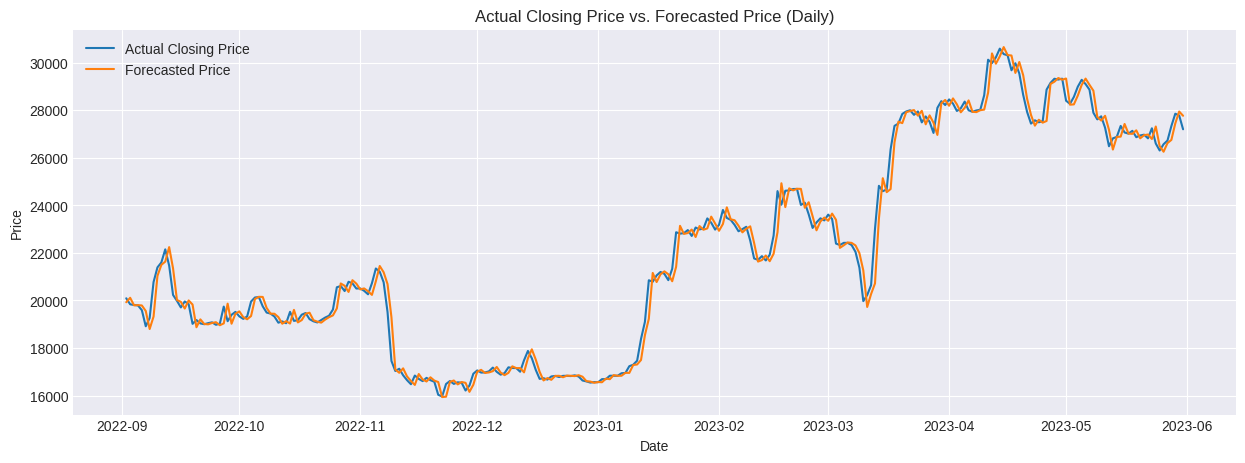

In [ ]:
# Plot whole timeframe

test_ar_day['Daily_Forecast_ARIMA'] = daily_predictions

day_df = pd.concat([train_ar_day, test_ar_day], sort=False)

plt.figure(figsize=(15, 5))

plt.plot(day_df['date'][- len(y_test_d):], day_df['close'][- len(y_test_d):], label='Actual Closing Price')
plt.plot(day_df['date'][- len(y_test_d):], day_df['Daily_Forecast_ARIMA'][- len(y_test_d):], label='Forecasted Price')

plt.xlabel('Date')
plt.ylabel('Price')

plt.title('Actual Closing Price vs. Forecasted Price (Daily)')

plt.legend()

plt.show();

In [ ]:
# Results ARIMA Daily Model

test_mae_ar = round(mean_absolute_error(test_ar_day['close'], test_ar_day['Daily_Forecast_ARIMA']))
test_rmse_ar = round(np.sqrt(mean_squared_error(test_ar_day['close'], test_ar_day['Daily_Forecast_ARIMA'])))
test_r2_ar = round((r2_score(test_ar_day['close'], test_ar_day['Daily_Forecast_ARIMA']))*100, 2)

print(f"test MAE ARIMA : {test_mae_ar}")
print(f"test RMSE ARIMA : {test_rmse_ar}")
print(f"test R2 ARIMA : {test_r2_ar}")

test MAE ARIMA : 315
test RMSE ARIMA : 476
test R2 ARIMA : 98.79


In [ ]:
# save model
model_fit_d.save("/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/BTC/ARIMA_d_BTC_(1,1,0).pkl")

# # # load model
# loaded = ARIMAResults.load('model.pkl')

## Hourly Dataframe

In [ ]:
data_BTC.reset_index(inplace = True)

In [ ]:
# Train/Test Split

split_date = "2022-09-01"

train_split = data_BTC['date'] <= split_date
test_split = data_BTC['date'] > split_date

train_ar = data_BTC[train_split]
test_ar = data_BTC[test_split]

columns = ['open', 'high', 'low', 'Volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']

X_train, y_train = train_ar[columns], train_ar.close
X_test, y_test = test_ar[columns], test_ar.close

In [ ]:
# Creating a list of values

training_list = list(y_train)
test_list = list(y_test)

In [ ]:
len(training_list), len(test_list)

(26271, 6550)

In [ ]:
# Predict the values aggregating to the training list, the previous calculated values in a for loop

hourly_predictions = []

for i in range(len(y_test)):
  model = ARIMA(training_list, order=(0,1,0))
  model_fit = model.fit()
  hourly_forecast = model_fit.forecast()[0]

  hourly_predictions.append(hourly_forecast)

  test_i = test_list[i]

  training_list.append(test_i)


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                32820
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -226934.838
Date:                Wed, 21 Jun 2023   AIC                         453871.676
Time:                        01:07:23   BIC                         453880.075
Sample:                             0   HQIC                        453874.360
                              - 32820                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.937e+04    133.274    445.484      0.000    5.91e+04    5.96e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):            674035.83
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               6.29   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plots Hourly

<ipython-input-30-e2f91f72c2c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ar['Hourly_Forecast_ARIMA'] = model_predictions


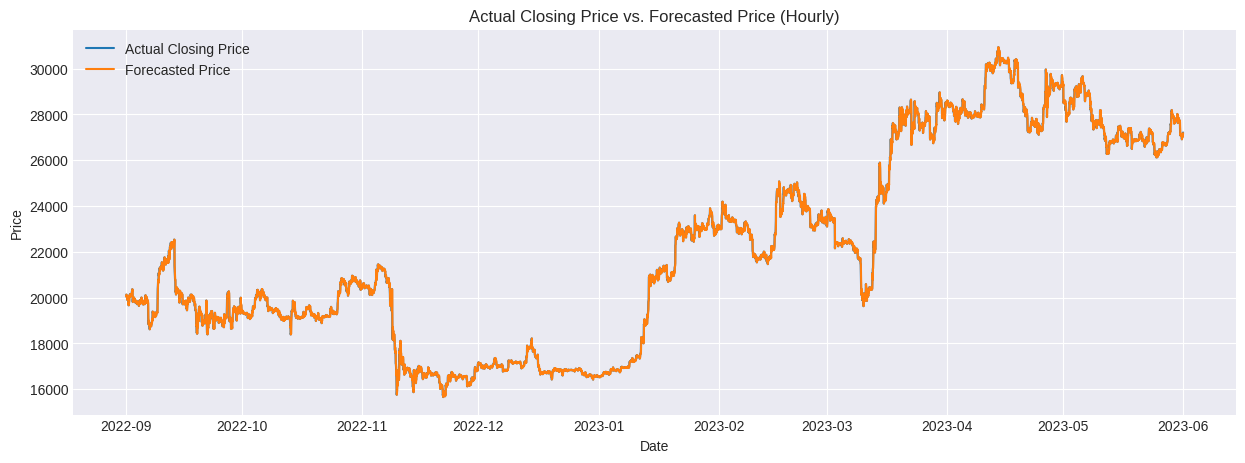

In [ ]:
# Plot whole timeframe

test_ar['Hourly_Forecast_ARIMA'] = hourly_predictions

hour_df = pd.concat([train_ar, test_ar], sort=False)


plt.figure(figsize=(15, 5))

plt.plot(hour_df['date'][- len(y_test):], hour_df['close'][- len(y_test):], label='Actual Closing Price')
plt.plot(hour_df['date'][- len(y_test):], hour_df['Hourly_Forecast_ARIMA'][- len(y_test):], label='Forecasted Price')

plt.xlabel('Date')
plt.ylabel('Price')

plt.title('Actual Closing Price vs. Forecasted Price (Hourly)')

plt.legend()

plt.show();

In [ ]:
# Results ARIMA Hourly Model

test_mae_ar_h = round(mean_absolute_error(test_ar['close'], test_ar['Hourly_Forecast_ARIMA']))
test_rmse_ar_h = round(np.sqrt(mean_squared_error(test_ar['close'], test_ar['Hourly_Forecast_ARIMA'])))
test_r2_ar_h = round((r2_score(test_ar['close'], test_ar['Hourly_Forecast_ARIMA']))*100, 2)


print(f"test MAE ARIMA : {test_mae_ar_h}")
print(f"test RMSE ARIMA : {test_rmse_ar_h}")
print(f"test R2 ARIMA : {test_r2_ar_h}")

test MAE ARIMA : 69
test RMSE ARIMA : 120
test R2 ARIMA : 99.92


In [ ]:
# save model
model_fit.save("/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/BTC/ARIMA_h_BTC_(0,1,0).pkl")

# # # load model
# loaded = ARIMAResults.load('model.pkl')

## Results Modeling

In [ ]:
# Overall Results

results = {
    "METRIC": ["MAE", "RMSE", "R2"],
    "ARIMA_Daily": [test_mae_ar, test_rmse_ar, test_r2_ar],
    "ARIMA_Hourly": [test_mae_ar_h, test_rmse_ar_h, test_r2_ar_h]

}

df_results = pd.DataFrame(results)
df_results

,METRIC,ARIMA_Daily,ARIMA_Hourly
0,MAE,315.00,69.00
1,RMSE,476.00,120.00
2,R2,98.79,99.92
